In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import os
from utils import PATH_DATA,PATH_MODELS,PATH_DATA_TEST

In [2]:
os.chdir(r'E:\study\else\RC-Raspberry-Pi-Car-with-Gesture-Control\realtime_gesture_recog')

In [3]:
classes = ('turn_left','turn_right','back_up','go_ahead','idle','nothing')


In [4]:
torch.__version__


'1.4.0'

# 1. Fetch Data

In [5]:
print(os.getcwd())

E:\study\else\RC-Raspberry-Pi-Car-with-Gesture-Control\realtime_gesture_recog


In [7]:
# load data
data_transform = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
gesture_dataset = datasets.ImageFolder(root=PATH_DATA,transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(gesture_dataset,
                                             batch_size=6, shuffle=True,
                                             num_workers=2)
test_dataset = datasets.ImageFolder(root=PATH_DATA_TEST,transform=data_transform)
testset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=6, shuffle=True,
                                             num_workers=2)

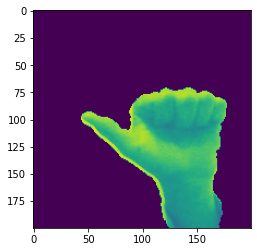

In [9]:
# source image
img_sample = io.imread(PATH_DATA+'/0_turn_left/0_turn_left1.png')
plt.imshow(img_sample)

In [10]:
# helper func
def imshow(img):
    # input: img, tensor CxHxW
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


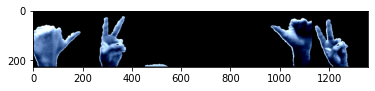

turn_right go_ahead nothing nothing turn_left go_ahead


In [11]:
# get some random training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))


In [12]:
dataset_loader.dataset

Dataset ImageFolder
    Number of datapoints: 1806
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
gesture_dataset.class_to_idx


{'0_turn_left': 0,
 '1_turn_right': 1,
 '2_back_up': 2,
 '3_go_ahead': 3,
 '4_idle': 4,
 '5_nothing': 5}

# 2. Try MobileNet v2

In [13]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'mobilenet_v2', pretrained=False)

Using cache found in C:\Users\24400/.cache\torch\hub\pytorch_vision_v0.5.0


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [45]:
print('start training')
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data  #use CPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Finished Training')


start training
[1,     5] loss: 6.794
[1,    10] loss: 6.179
[1,    15] loss: 5.132
[1,    20] loss: 3.942
[1,    25] loss: 3.153
[1,    30] loss: 2.677
[1,    35] loss: 2.211
[1,    40] loss: 2.170
[1,    45] loss: 2.034
[1,    50] loss: 1.972
[1,    55] loss: 1.923
[1,    60] loss: 1.864
[1,    65] loss: 1.773
[1,    70] loss: 1.981
[1,    75] loss: 1.753
[2,     5] loss: 1.724
[2,    10] loss: 1.775
[2,    15] loss: 1.740
[2,    20] loss: 1.691
[2,    25] loss: 1.741
[2,    30] loss: 1.689
[2,    35] loss: 1.617
[2,    40] loss: 1.788
[2,    45] loss: 1.565
[2,    50] loss: 1.567
[2,    55] loss: 1.502
[2,    60] loss: 1.428
[2,    65] loss: 1.512
[2,    70] loss: 1.602
[2,    75] loss: 1.559
Finished Training


# 3. Test Tensorboard

In [16]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/exp1')

In [29]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False, gpu=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    if gpu:
        img=img.cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

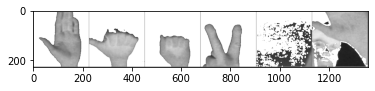

In [18]:
# get some random training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [19]:
writer.add_graph(model, images)
writer.close()



In [8]:
# helper functions

def images_to_probs(net, images, gpu=True):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    if gpu:
        preds_tensor=preds_tensor.cpu()
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]



In [9]:
def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## use tensorboard to visualize training

In [31]:
print('start training')
record_intervals = 10
running_loss = 0.0
for epoch in range(30):  # loop over the dataset multiple times

    for i, data in enumerate(dataset_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data  #use CPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % record_intervals == record_intervals-1:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / record_intervals,
                            epoch * len(dataset_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(dataset_loader) + i)
            running_loss = 0.0
print('Finished Training')



start training
Finished Training


In [36]:
PATH_MODELS = './weights'

In [10]:
# save model
torch.save(model.state_dict(),PATH_MODELS+'/mobilev2_1')

NameError: name 'model' is not defined

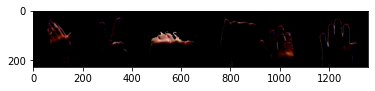

GroundTruth:  back_up go_ahead turn_right  idle


In [40]:
# just test training test
dataiter = iter(dataset_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
# reload model
model = torch.hub.load('pytorch/vision:v0.5.0', 'mobilenet_v2', pretrained=False)
model.load_state_dict(torch.load(PATH_MODELS+'/mobilev2_1'))

Using cache found in C:\Users\24400/.cache\torch\hub\pytorch_vision_v0.5.0


<All keys matched successfully>

In [42]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  back_up go_ahead turn_right  idle


In [44]:
# evaluate each class
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in dataset_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(6):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataset_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the images: 99 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


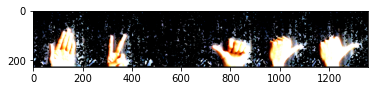

In [12]:
# try some new data

dataiter = iter(testset_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))

In [16]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

Predicted:  nothing go_ahead turn_left turn_left turn_right turn_right
